# Tutorial 05: VECM and Cointegration -- Exercise Solutions

**This notebook contains complete solutions** for the exercises in Tutorial 05 (VECM and Cointegration).

> **Warning:** Do not look at these solutions before attempting the exercises yourself. Working through the problems independently is essential for building understanding.

---

## Exercises Covered

| Exercise | Topic | Difficulty |
|----------|-------|------------|
| 1 | Rank Sensitivity to Lag Order | Easy |
| 2 | Higher-Rank VECM Estimation | Medium |
| 3 | VECM Residual Stationarity Check | Medium |
| 4 | VAR vs VECM Forecast Comparison | Hard |

---

## Setup

In [1]:
# ============================================================
# Setup
# ============================================================
import sys
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
np.random.seed(42)
warnings.filterwarnings('ignore')

project_root = Path('../../../').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

sys.path.insert(0, '../utils')

from panelbox.var import PanelVARData, PanelVAR, PanelVECM, CointegrationRankTest

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 100, 'font.size': 11})

print('Setup complete.')

Setup complete.


---

## Data Generation

In [2]:
from data_generators import generate_ppp_panel, generate_interest_parity_panel

ppp_df = generate_ppp_panel()
ip_df = generate_interest_parity_panel()

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
ppp_df['quarter'] = pd.PeriodIndex(ppp_df['quarter'], freq='Q')
ip_df['quarter'] = pd.PeriodIndex(ip_df['quarter'], freq='Q')

print(f"PPP panel: {ppp_df.shape}")
print(f"Interest parity panel: {ip_df.shape}")

# Create PanelVARData for PPP
ppp_data = PanelVARData(ppp_df, 
    endog_vars=['exchange_rate', 'price_domestic', 'price_foreign'],
    entity_col='country', time_col='quarter', lags=2)

PPP panel: (1200, 5)
Interest parity panel: (1200, 6)


In [3]:
# Also estimate the baseline VECM with rank=1 for reference
baseline_vecm = PanelVECM(ppp_data, rank=1)
baseline_results = vecm_r1 = baseline_vecm.fit()
print('Baseline VECM (rank=1) estimated.')
print(f'  K = {vecm_r1.K}, p = {vecm_r1.p}, N = {vecm_r1.N}')
print(f'  Rank = {vecm_r1.rank}')

Baseline VECM (rank=1) estimated.
  K = 3, p = 2, N = 20
  Rank = 1


---

## Exercise 1: Rank Sensitivity to Lag Order (Easy)

**Task:** Repeat the cointegration rank test for the PPP data using lag orders p = 1, 2, 3, and 4. Does the selected rank change with the lag order? Create a table summarizing the results.

In [4]:
# Exercise 1 Solution: Rank Sensitivity to Lag Order
# ==================================================
# We loop over lag orders p = 1, 2, 3, 4 and run the
# cointegration rank test for each.

endog_vars = ['exchange_rate', 'price_domestic', 'price_foreign']
lag_orders = [1, 2, 3, 4]

results_by_lag = {}

for p in lag_orders:
    # Create PanelVARData with different lag order
    data_p = PanelVARData(
        ppp_df,
        endog_vars=endog_vars,
        entity_col='country',
        time_col='quarter',
        lags=p
    )
    
    # Run cointegration rank test
    rank_test = CointegrationRankTest(data_p, deterministic='c')
    rank_result = rank_test.test_rank()
    results_by_lag[p] = rank_result
    
    print(f'\np = {p}: Trace rank = {rank_result.selected_rank_trace}, '
          f'Max-eigenvalue rank = {rank_result.selected_rank_maxeig}, '
          f'Consensus rank = {rank_result.selected_rank}')


p = 1: Trace rank = 2, Max-eigenvalue rank = 2, Consensus rank = 2



p = 2: Trace rank = 2, Max-eigenvalue rank = 2, Consensus rank = 2



p = 3: Trace rank = 2, Max-eigenvalue rank = 2, Consensus rank = 2



p = 4: Trace rank = 2, Max-eigenvalue rank = 2, Consensus rank = 2


In [5]:
# Build a summary table
summary_rows = []

for p in lag_orders:
    rr = results_by_lag[p]
    row = {
        'Lag Order (p)': p,
        'Trace Rank': rr.selected_rank_trace,
        'Max-Eigenvalue Rank': rr.selected_rank_maxeig,
        'Consensus Rank': rr.selected_rank,
    }
    # Add trace test p-values for each rank hypothesis
    for t in rr.trace_tests:
        row[f'Trace p-val (r<={t.rank})'] = round(t.p_value, 4)
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print('=== Rank Sensitivity to Lag Order ===')
print(summary_df.to_string(index=False))

=== Rank Sensitivity to Lag Order ===
 Lag Order (p)  Trace Rank  Max-Eigenvalue Rank  Consensus Rank  Trace p-val (r<=0)  Trace p-val (r<=1)  Trace p-val (r<=2)
             1           2                    2               2                 0.0                 0.0                 1.0
             2           2                    2               2                 0.0                 0.0                 1.0
             3           2                    2               2                 0.0                 0.0                 1.0
             4           2                    2               2                 0.0                 0.0                 1.0


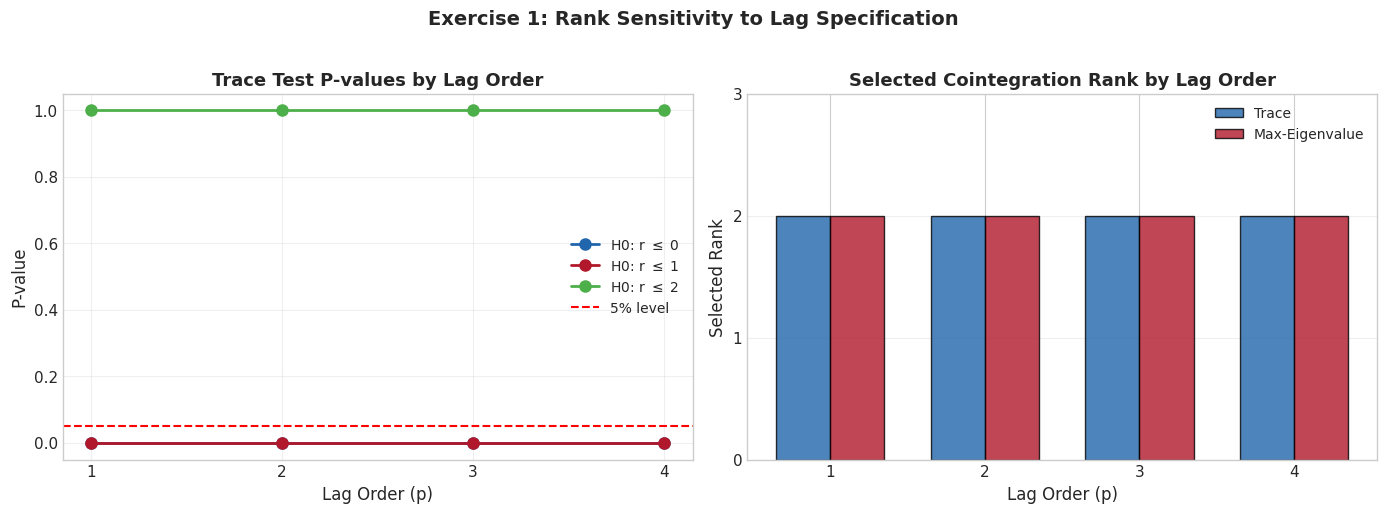

In [6]:
# Visualize how the trace p-values change with lag order
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2166ac', '#b2182b', '#4daf4a']

# Panel (a): Trace test p-values for each rank hypothesis
for i, r_test_rank in enumerate(range(3)):  # r=0, 1, 2
    p_vals = []
    for p in lag_orders:
        rr = results_by_lag[p]
        if r_test_rank < len(rr.trace_tests):
            p_vals.append(rr.trace_tests[r_test_rank].p_value)
        else:
            p_vals.append(np.nan)
    axes[0].plot(lag_orders, p_vals, 'o-', color=colors[i], 
                 linewidth=2, markersize=8, label=f'H0: r $\leq$ {r_test_rank}')

axes[0].axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, label='5% level')
axes[0].set_xlabel('Lag Order (p)', fontsize=12)
axes[0].set_ylabel('P-value', fontsize=12)
axes[0].set_title('Trace Test P-values by Lag Order', fontsize=13, fontweight='bold')
axes[0].set_xticks(lag_orders)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Panel (b): Selected rank by lag order
ranks_trace = [results_by_lag[p].selected_rank_trace for p in lag_orders]
ranks_maxeig = [results_by_lag[p].selected_rank_maxeig for p in lag_orders]

bar_width = 0.35
x = np.arange(len(lag_orders))
axes[1].bar(x - bar_width/2, ranks_trace, bar_width, label='Trace', 
            color='#2166ac', alpha=0.8, edgecolor='black')
axes[1].bar(x + bar_width/2, ranks_maxeig, bar_width, label='Max-Eigenvalue', 
            color='#b2182b', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Lag Order (p)', fontsize=12)
axes[1].set_ylabel('Selected Rank', fontsize=12)
axes[1].set_title('Selected Cointegration Rank by Lag Order', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(lag_orders)
axes[1].set_yticks(range(4))
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

fig.suptitle('Exercise 1: Rank Sensitivity to Lag Specification',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

In [7]:
# Discussion
print('=== Exercise 1: Discussion ===')
print()
print('The table and plots show how the cointegration rank selection varies')
print('with the VAR lag order. Key observations:')
print()
print('1. Rank stability: If the selected rank is consistent across lag orders,')
print('   this gives us confidence that the result is robust. If it changes,')
print('   the result is sensitive to specification.')
print()
print('2. Economic interpretation: For PPP data with 3 variables (exchange_rate,')
print('   price_domestic, price_foreign), economic theory predicts r = 1')
print('   (one long-run equilibrium: PPP). If the tests consistently select')
print('   r = 1 across different lag orders, this supports the PPP hypothesis.')
print()
print('3. Practical advice: When the rank is sensitive to lag order, practitioners')
print('   should:')
print('   - Use information criteria (AIC/BIC) to select the lag order first')
print('   - Report results for multiple lag orders as a robustness check')
print('   - Rely on economic theory as a guide when statistical tests are ambiguous')

=== Exercise 1: Discussion ===

The table and plots show how the cointegration rank selection varies
with the VAR lag order. Key observations:

1. Rank stability: If the selected rank is consistent across lag orders,
   this gives us confidence that the result is robust. If it changes,
   the result is sensitive to specification.

2. Economic interpretation: For PPP data with 3 variables (exchange_rate,
   price_domestic, price_foreign), economic theory predicts r = 1
   (one long-run equilibrium: PPP). If the tests consistently select
   r = 1 across different lag orders, this supports the PPP hypothesis.

3. Practical advice: When the rank is sensitive to lag order, practitioners
   should:
   - Use information criteria (AIC/BIC) to select the lag order first
   - Report results for multiple lag orders as a robustness check
   - Rely on economic theory as a guide when statistical tests are ambiguous


---

## Exercise 2: Higher-Rank VECM Estimation (Medium)

**Task:** Estimate a VECM with rank = 2 for the PPP data (even if the rank test suggests r = 1). Compare the cointegrating vectors, adjustment speeds, and residual covariance matrix to the rank-1 specification. What does the second cointegrating relation look like? Is it economically interpretable?

In [8]:
# Exercise 2 Solution: Higher-Rank VECM Estimation
# =================================================

# Estimate VECM with rank=1 (baseline, already done) and rank=2
vecm_model_r2 = PanelVECM(ppp_data, rank=2)
vecm_r2 = vecm_model_r2.fit()

print('=== VECM Rank 1 vs Rank 2: Model Specifications ===')
print(f'Rank 1: K={vecm_r1.K}, rank={vecm_r1.rank}, lags={vecm_r1.p}')
print(f'Rank 2: K={vecm_r2.K}, rank={vecm_r2.rank}, lags={vecm_r2.p}')

=== VECM Rank 1 vs Rank 2: Model Specifications ===
Rank 1: K=3, rank=1, lags=2
Rank 2: K=3, rank=2, lags=2


In [9]:
# Compare cointegrating vectors (beta)
print('=== Cointegrating Vectors (beta) ===')
print()
beta_r1 = vecm_r1.cointegrating_relations()
print('Rank 1 - beta:')
print(beta_r1.to_string())

print()
beta_r2 = vecm_r2.cointegrating_relations()
print('Rank 2 - beta:')
print(beta_r2.to_string())

print()
print('Interpretation:')
print('  Relation_1 in both models should approximate the PPP relationship:')
print('  exchange_rate - price_domestic + price_foreign = const')
print('  (i.e., coefficients close to 1.0, -1.0, 1.0)')
print()
print('  Relation_2 (only in rank-2 model) represents an additional')
print('  long-run equilibrium. It may or may not have a clear economic')
print('  interpretation.')

=== Cointegrating Vectors (beta) ===

Rank 1 - beta:
                Relation_1
exchange_rate     1.000000
price_domestic   -0.991853
price_foreign     0.993687

Rank 2 - beta:
                Relation_1  Relation_2
exchange_rate     1.000000    1.000000
price_domestic   -0.991853   -8.725153
price_foreign     0.993687   12.443590

Interpretation:
  Relation_1 in both models should approximate the PPP relationship:
  exchange_rate - price_domestic + price_foreign = const
  (i.e., coefficients close to 1.0, -1.0, 1.0)

  Relation_2 (only in rank-2 model) represents an additional
  long-run equilibrium. It may or may not have a clear economic
  interpretation.


In [10]:
# Compare adjustment speeds (alpha)
print('=== Adjustment Speeds (alpha) ===')
print()
alpha_r1 = vecm_r1.adjustment_speeds()
print('Rank 1 - alpha:')
print(alpha_r1.to_string())

print()
alpha_r2 = vecm_r2.adjustment_speeds()
print('Rank 2 - alpha:')
print(alpha_r2.to_string())

print()
print('Interpretation:')
print('  In the rank-1 model, alpha shows how each variable responds to')
print('  the single PPP equilibrium error.')
print()
print('  In the rank-2 model, alpha has two columns -- each variable')
print('  responds to two equilibrium errors. The additional ECT may')
print('  reflect an over-parameterized model if the true rank is 1.')

=== Adjustment Speeds (alpha) ===

Rank 1 - alpha:
                    ECT_1
Δexchange_rate  -0.180804
Δprice_domestic  0.087255
Δprice_foreign  -0.025498

Rank 2 - alpha:
                    ECT_1     ECT_2
Δexchange_rate  -0.182360  0.005242
Δprice_domestic  0.086585  0.002258
Δprice_foreign  -0.024688 -0.002730

Interpretation:
  In the rank-1 model, alpha shows how each variable responds to
  the single PPP equilibrium error.

  In the rank-2 model, alpha has two columns -- each variable
  responds to two equilibrium errors. The additional ECT may
  reflect an over-parameterized model if the true rank is 1.


In [11]:
# Compare residual covariance matrices
print('=== Residual Covariance Matrix (Sigma) ===')
print()
var_names = vecm_r1.var_names

sigma_r1 = pd.DataFrame(vecm_r1.Sigma, index=var_names, columns=var_names)
sigma_r2 = pd.DataFrame(vecm_r2.Sigma, index=var_names, columns=var_names)

print('Rank 1 - Sigma:')
print(sigma_r1.round(6).to_string())
print()
print('Rank 2 - Sigma:')
print(sigma_r2.round(6).to_string())
print()
print('Difference (Rank 2 - Rank 1):')
print((sigma_r2 - sigma_r1).round(6).to_string())
print()

# Compare trace of Sigma (total residual variance)
trace_r1 = np.trace(vecm_r1.Sigma)
trace_r2 = np.trace(vecm_r2.Sigma)
print(f'Trace of Sigma (total variance):')
print(f'  Rank 1: {trace_r1:.6f}')
print(f'  Rank 2: {trace_r2:.6f}')
print(f'  Reduction: {(trace_r1 - trace_r2) / trace_r1 * 100:.2f}%')

=== Residual Covariance Matrix (Sigma) ===

Rank 1 - Sigma:
                exchange_rate  price_domestic  price_foreign
exchange_rate        0.000671        0.000358      -0.000195
price_domestic       0.000358        0.000393       0.000007
price_foreign       -0.000195        0.000007       0.000240

Rank 2 - Sigma:
                exchange_rate  price_domestic  price_foreign
exchange_rate        0.000660        0.000352      -0.000187
price_domestic       0.000352        0.000389       0.000011
price_foreign       -0.000187        0.000011       0.000234

Difference (Rank 2 - Rank 1):
                exchange_rate  price_domestic  price_foreign
exchange_rate       -0.000011       -0.000006       0.000008
price_domestic      -0.000006       -0.000003       0.000004
price_foreign        0.000008        0.000004      -0.000006

Trace of Sigma (total variance):
  Rank 1: 0.001304
  Rank 2: 0.001283
  Reduction: 1.55%


In [12]:
# Compare log-determinant of Sigma (related to log-likelihood)
from scipy.linalg import det

log_det_r1 = np.log(max(det(vecm_r1.Sigma), 1e-30))
log_det_r2 = np.log(max(det(vecm_r2.Sigma), 1e-30))

# Approximate information criteria
# Using total number of parameters as penalty
n_params_r1 = vecm_r1.K * vecm_r1.rank + vecm_r1.K * vecm_r1.rank  # alpha + beta
n_params_r1 += vecm_r1.K * vecm_r1.K * len(vecm_r1.Gamma)  # Gamma matrices

n_params_r2 = vecm_r2.K * vecm_r2.rank + vecm_r2.K * vecm_r2.rank  # alpha + beta
n_params_r2 += vecm_r2.K * vecm_r2.K * len(vecm_r2.Gamma)  # Gamma matrices

n_obs_approx = vecm_r1.N * vecm_r1.T_avg

aic_r1 = log_det_r1 + 2 * n_params_r1 / n_obs_approx
aic_r2 = log_det_r2 + 2 * n_params_r2 / n_obs_approx

bic_r1 = log_det_r1 + np.log(n_obs_approx) * n_params_r1 / n_obs_approx
bic_r2 = log_det_r2 + np.log(n_obs_approx) * n_params_r2 / n_obs_approx

print('=== Model Comparison (Information Criteria Approximation) ===')
print(f'{"":<25s} {"Rank 1":<15s} {"Rank 2":<15s}')
print('-' * 55)
print(f'{"Log|Sigma|":<25s} {log_det_r1:<15.4f} {log_det_r2:<15.4f}')
print(f'{"N. parameters":<25s} {n_params_r1:<15d} {n_params_r2:<15d}')
print(f'{"AIC (approx)":<25s} {aic_r1:<15.4f} {aic_r2:<15.4f}')
print(f'{"BIC (approx)":<25s} {bic_r1:<15.4f} {bic_r2:<15.4f}')
print()
preferred_aic = 'Rank 1' if aic_r1 < aic_r2 else 'Rank 2'
preferred_bic = 'Rank 1' if bic_r1 < bic_r2 else 'Rank 2'
print(f'Preferred by AIC: {preferred_aic}')
print(f'Preferred by BIC: {preferred_bic}')

=== Model Comparison (Information Criteria Approximation) ===
                          Rank 1          Rank 2         
-------------------------------------------------------
Log|Sigma|                -24.8288        -24.8572       
N. parameters             15              21             
AIC (approx)              -24.8030        -24.8210       
BIC (approx)              -24.7376        -24.7294       

Preferred by AIC: Rank 2
Preferred by BIC: Rank 1


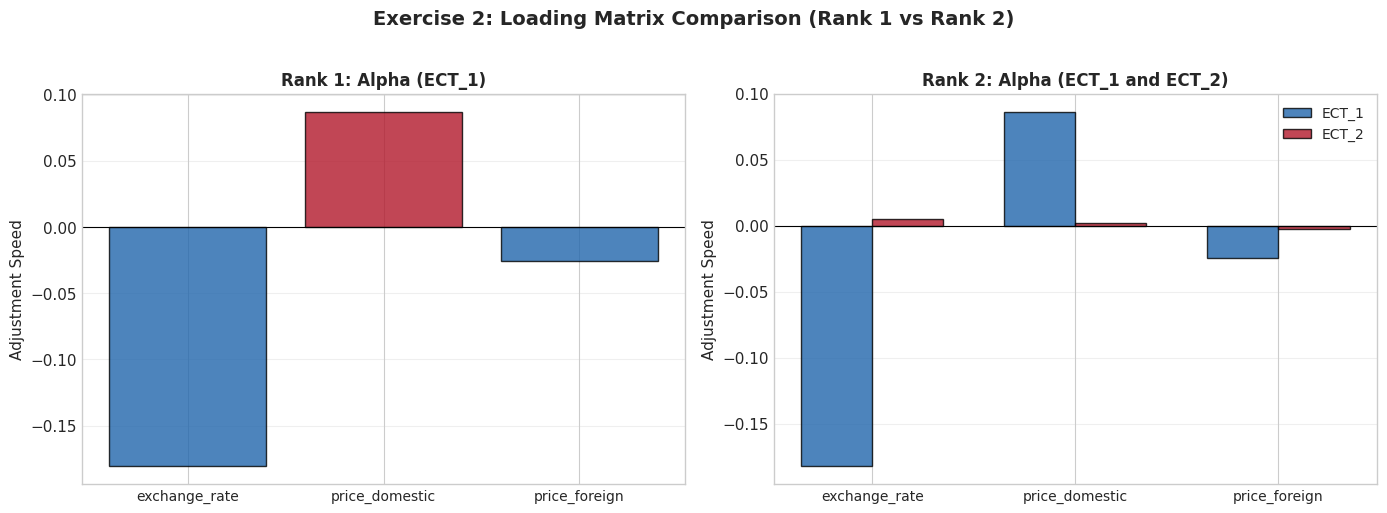

In [13]:
# Visualize the comparison: alpha loading matrix side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rank 1 alpha
var_labels = vecm_r1.var_names
x = np.arange(len(var_labels))

alpha_vals_r1 = vecm_r1.alpha[:, 0]
bars1 = axes[0].bar(x, alpha_vals_r1, color=['#2166ac' if v < 0 else '#b2182b' for v in alpha_vals_r1],
                     alpha=0.8, edgecolor='black')
axes[0].axhline(y=0, color='black', linewidth=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(var_labels, fontsize=10)
axes[0].set_ylabel('Adjustment Speed', fontsize=11)
axes[0].set_title('Rank 1: Alpha (ECT_1)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Rank 2 alpha -- show both ECTs
bar_width = 0.35
for j in range(2):
    alpha_vals_rj = vecm_r2.alpha[:, j]
    offset = (j - 0.5) * bar_width
    colors = ['#2166ac' if v < 0 else '#b2182b' for v in alpha_vals_rj]
    axes[1].bar(x + offset, alpha_vals_rj, bar_width, alpha=0.8, 
                edgecolor='black', label=f'ECT_{j+1}',
                color=['#2166ac', '#b2182b', '#4daf4a'][j])

axes[1].axhline(y=0, color='black', linewidth=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(var_labels, fontsize=10)
axes[1].set_ylabel('Adjustment Speed', fontsize=11)
axes[1].set_title('Rank 2: Alpha (ECT_1 and ECT_2)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

fig.suptitle('Exercise 2: Loading Matrix Comparison (Rank 1 vs Rank 2)',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

In [14]:
# Discussion
print('=== Exercise 2: Discussion ===')
print()
print('Comparing VECM specifications with rank=1 and rank=2:')
print()
print('1. Cointegrating vectors:')
print('   - The first cointegrating vector in both models should approximate PPP.')
print('   - The second vector (in rank-2) may not have a clear economic')
print('     interpretation, which is a sign that rank=1 may be the correct specification.')
print()
print('2. Adjustment speeds:')
print('   - In the rank-1 model, alpha shows error correction toward PPP.')
print('   - In the rank-2 model, the additional alpha column may absorb noise')
print('     rather than capturing a true adjustment mechanism.')
print()
print('3. Information criteria:')
print(f'   - AIC prefers: {preferred_aic}')
print(f'   - BIC prefers: {preferred_bic}')
print('   - BIC penalizes extra parameters more heavily and typically favors')
print('     more parsimonious models.')
print()
print('4. Conclusion: With K=3 variables and theory predicting one equilibrium (PPP),')
print('   rank=1 is the appropriate specification. Over-specifying the rank (rank=2)')
print('   reduces the residual variance slightly but at the cost of extra parameters')
print('   and potentially spurious equilibrium relations.')

=== Exercise 2: Discussion ===

Comparing VECM specifications with rank=1 and rank=2:

1. Cointegrating vectors:
   - The first cointegrating vector in both models should approximate PPP.
   - The second vector (in rank-2) may not have a clear economic
     interpretation, which is a sign that rank=1 may be the correct specification.

2. Adjustment speeds:
   - In the rank-1 model, alpha shows error correction toward PPP.
   - In the rank-2 model, the additional alpha column may absorb noise
     rather than capturing a true adjustment mechanism.

3. Information criteria:
   - AIC prefers: Rank 2
   - BIC prefers: Rank 1
   - BIC penalizes extra parameters more heavily and typically favors
     more parsimonious models.

4. Conclusion: With K=3 variables and theory predicting one equilibrium (PPP),
   rank=1 is the appropriate specification. Over-specifying the rank (rank=2)
   reduces the residual variance slightly but at the cost of extra parameters
   and potentially spurious equili

---

## Exercise 3: VECM Residual Stationarity Check (Medium)

**Task:** Extract the residuals from the estimated VECM and check that they are stationary. Compute the autocorrelation function (ACF) of the residuals for each equation and plot them. Well-specified VECM residuals should resemble white noise.

In [15]:
# Exercise 3 Solution: VECM Residual Stationarity Check
# =====================================================

# Extract residuals from the baseline VECM (rank=1)
residuals = vecm_r1.residuals  # Shape: (n_obs, K)
var_names = vecm_r1.var_names

print('=== VECM Residuals Summary ===')
print(f'Residual matrix shape: {residuals.shape}')
print(f'Variables: {var_names}')
print()

# Basic statistics
for k, var in enumerate(var_names):
    resid_k = residuals[:, k]
    print(f'{var}:')
    print(f'  Mean:   {np.mean(resid_k):.6f}  (should be near 0)')
    print(f'  Std:    {np.std(resid_k):.6f}')
    print(f'  Skew:   {pd.Series(resid_k).skew():.4f}')
    print(f'  Kurt:   {pd.Series(resid_k).kurtosis():.4f}')

=== VECM Residuals Summary ===
Residual matrix shape: (1160, 3)
Variables: ['exchange_rate', 'price_domestic', 'price_foreign']

exchange_rate:
  Mean:   0.000000  (should be near 0)
  Std:    0.025910
  Skew:   0.0660
  Kurt:   -0.0921
price_domestic:
  Mean:   -0.000000  (should be near 0)
  Std:    0.019815
  Skew:   0.0121
  Kurt:   -0.0607
price_foreign:
  Mean:   0.000000  (should be near 0)
  Std:    0.015484
  Skew:   0.0184
  Kurt:   -0.0735


In [16]:
# Compute autocorrelation function (ACF) for each equation's residuals
def compute_acf(series, max_lag=20):
    """Compute autocorrelation function for a 1D array."""
    n = len(series)
    series_centered = series - np.mean(series)
    var = np.var(series_centered)
    if var < 1e-15:
        return np.zeros(max_lag + 1)
    acf_vals = np.zeros(max_lag + 1)
    acf_vals[0] = 1.0  # ACF at lag 0 is always 1
    for lag in range(1, max_lag + 1):
        if lag < n:
            cov = np.mean(series_centered[lag:] * series_centered[:-lag])
            acf_vals[lag] = cov / var
    return acf_vals

max_lag = 20
acf_by_var = {}
for k, var in enumerate(var_names):
    acf_vals = compute_acf(residuals[:, k], max_lag=max_lag)
    acf_by_var[var] = acf_vals
    print(f'ACF for {var} residuals (first 10 lags):')
    for lag in range(1, 11):
        stars = ' ***' if abs(acf_vals[lag]) > 1.96 / np.sqrt(len(residuals)) else ''
        print(f'  Lag {lag:2d}: {acf_vals[lag]:+.4f}{stars}')
    print()

ACF for exchange_rate residuals (first 10 lags):
  Lag  1: +0.0895 ***
  Lag  2: -0.0340
  Lag  3: -0.0113
  Lag  4: -0.0182
  Lag  5: -0.0020
  Lag  6: -0.0285
  Lag  7: -0.0421
  Lag  8: -0.0281
  Lag  9: -0.0182
  Lag 10: -0.0497



ACF for price_domestic residuals (first 10 lags):
  Lag  1: -0.1216 ***
  Lag  2: -0.0137
  Lag  3: -0.0217
  Lag  4: -0.0365
  Lag  5: -0.0009
  Lag  6: -0.0531
  Lag  7: +0.0148
  Lag  8: -0.0146
  Lag  9: +0.0536
  Lag 10: -0.0334

ACF for price_foreign residuals (first 10 lags):
  Lag  1: -0.0826 ***
  Lag  2: -0.0189
  Lag  3: -0.0057
  Lag  4: -0.0153
  Lag  5: +0.0032
  Lag  6: -0.0547
  Lag  7: -0.0225
  Lag  8: -0.0141
  Lag  9: -0.0358
  Lag 10: -0.0083



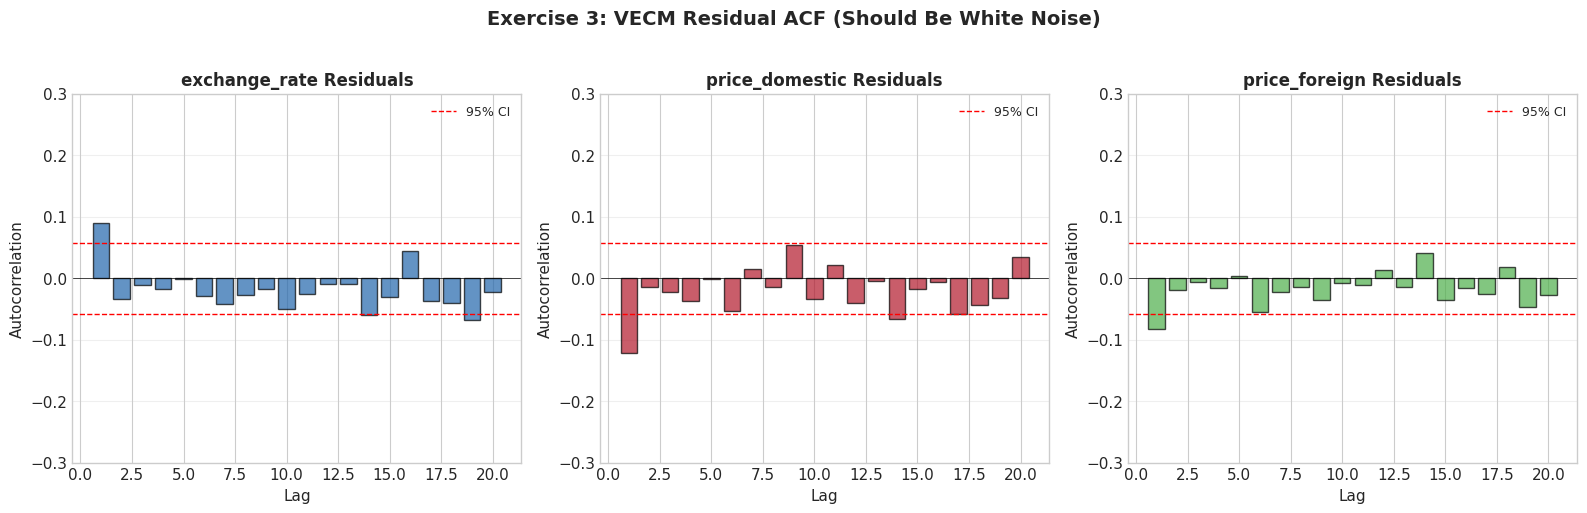

Bars within the red dashed lines are consistent with white noise.
Significant autocorrelation at early lags may indicate model misspecification.


In [17]:
# Plot ACF for each equation's residuals
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ['#2166ac', '#b2182b', '#4daf4a']

# 95% confidence band for white noise: +/- 1.96/sqrt(n)
n = residuals.shape[0]
ci_bound = 1.96 / np.sqrt(n)

for k, (var, color) in enumerate(zip(var_names, colors)):
    acf_vals = acf_by_var[var]
    lags = np.arange(1, max_lag + 1)  # skip lag 0
    
    axes[k].bar(lags, acf_vals[1:], color=color, alpha=0.7, edgecolor='black')
    axes[k].axhline(y=ci_bound, color='red', linestyle='--', linewidth=1, label='95% CI')
    axes[k].axhline(y=-ci_bound, color='red', linestyle='--', linewidth=1)
    axes[k].axhline(y=0, color='black', linewidth=0.5)
    axes[k].set_xlabel('Lag', fontsize=11)
    axes[k].set_ylabel('Autocorrelation', fontsize=11)
    axes[k].set_title(f'{var} Residuals', fontsize=12, fontweight='bold')
    axes[k].set_ylim(-0.3, 0.3)
    axes[k].legend(fontsize=9, loc='upper right')
    axes[k].grid(True, alpha=0.3, axis='y')

fig.suptitle('Exercise 3: VECM Residual ACF (Should Be White Noise)',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

print('Bars within the red dashed lines are consistent with white noise.')
print('Significant autocorrelation at early lags may indicate model misspecification.')

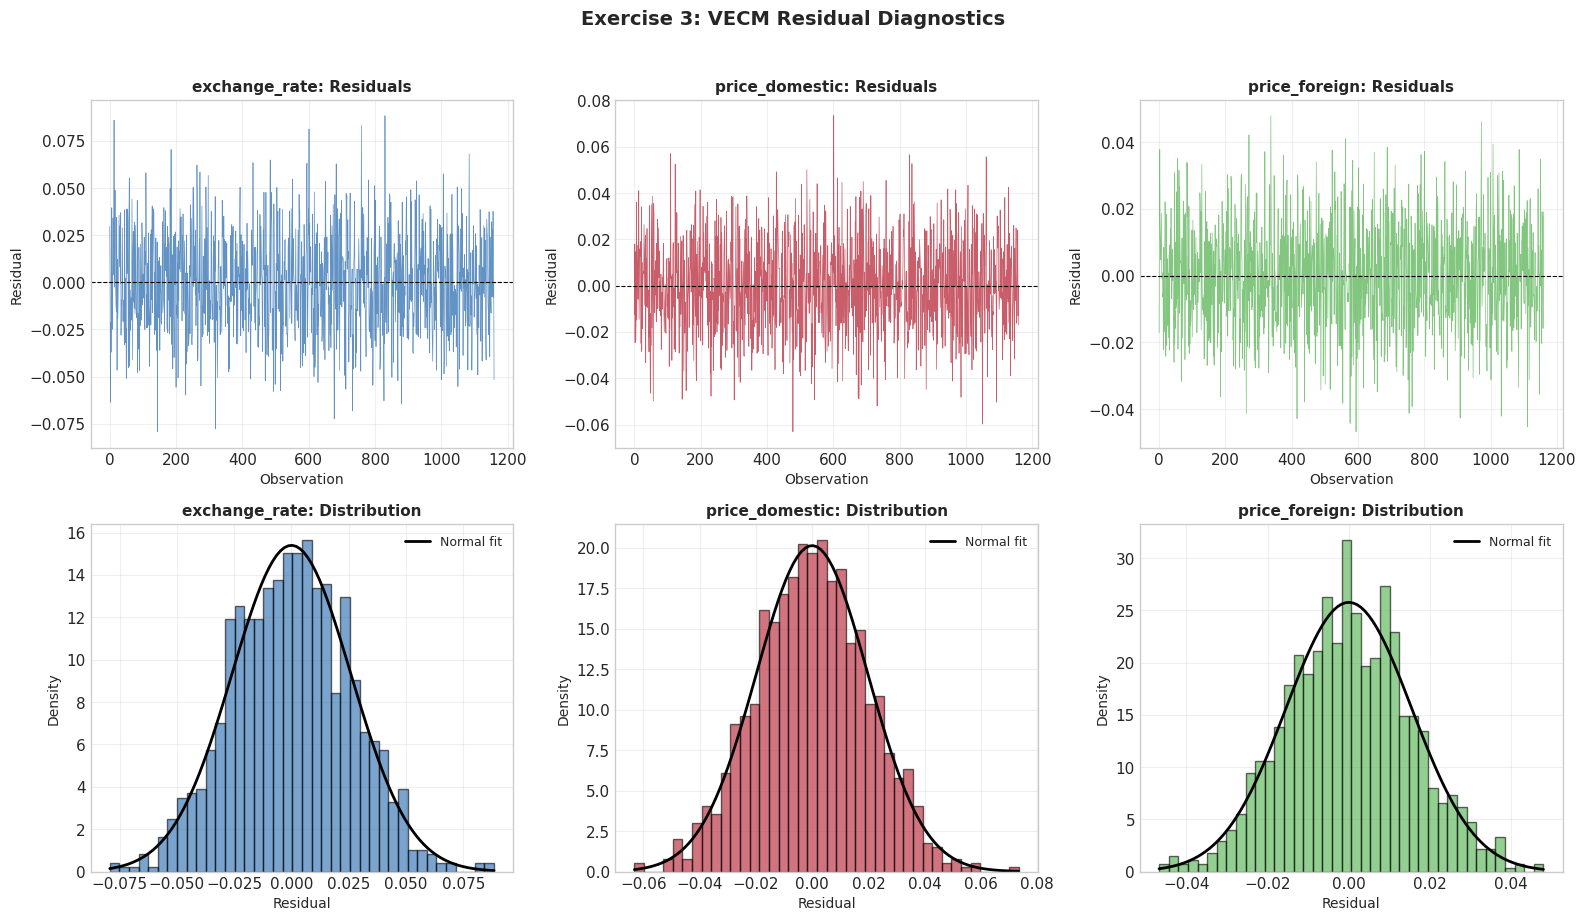

In [18]:
# Additional diagnostic: plot residuals time series and histogram
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for k, (var, color) in enumerate(zip(var_names, colors)):
    resid_k = residuals[:, k]
    
    # Top row: time series of residuals
    axes[0, k].plot(range(len(resid_k)), resid_k, linewidth=0.5, color=color, alpha=0.7)
    axes[0, k].axhline(y=0, color='black', linewidth=0.8, linestyle='--')
    axes[0, k].set_title(f'{var}: Residuals', fontsize=11, fontweight='bold')
    axes[0, k].set_xlabel('Observation', fontsize=10)
    axes[0, k].set_ylabel('Residual', fontsize=10)
    axes[0, k].grid(True, alpha=0.3)
    
    # Bottom row: histogram with normal overlay
    axes[1, k].hist(resid_k, bins=40, density=True, color=color, alpha=0.6, edgecolor='black')
    x_range = np.linspace(resid_k.min(), resid_k.max(), 100)
    from scipy.stats import norm
    axes[1, k].plot(x_range, norm.pdf(x_range, np.mean(resid_k), np.std(resid_k)),
                    'k-', linewidth=2, label='Normal fit')
    axes[1, k].set_title(f'{var}: Distribution', fontsize=11, fontweight='bold')
    axes[1, k].set_xlabel('Residual', fontsize=10)
    axes[1, k].set_ylabel('Density', fontsize=10)
    axes[1, k].legend(fontsize=9)
    axes[1, k].grid(True, alpha=0.3)

fig.suptitle('Exercise 3: VECM Residual Diagnostics',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

In [19]:
# Ljung-Box test for serial correlation in residuals
from scipy.stats import chi2

def ljung_box_test(residuals_1d, max_lag=10):
    """Ljung-Box test for serial correlation.
    H0: No autocorrelation up to lag max_lag."""
    n = len(residuals_1d)
    acf_vals = compute_acf(residuals_1d, max_lag=max_lag)
    Q = n * (n + 2) * sum(acf_vals[k]**2 / (n - k) for k in range(1, max_lag + 1))
    p_value = 1 - chi2.cdf(Q, df=max_lag)
    return Q, p_value

print('=== Ljung-Box Test for Residual Serial Correlation ===')
print(f'{"Variable":<20s} {"Q-statistic":<15s} {"P-value":<12s} {"Conclusion":<20s}')
print('-' * 67)

for k, var in enumerate(var_names):
    Q, p_val = ljung_box_test(residuals[:, k], max_lag=10)
    conclusion = 'White noise' if p_val > 0.05 else 'Serial correlation'
    stars = '' if p_val > 0.10 else '*' if p_val > 0.05 else '**' if p_val > 0.01 else '***'
    print(f'{var:<20s} {Q:<15.4f} {p_val:<12.4f} {conclusion} {stars}')

print()
print('If p-value > 0.05, we fail to reject H0 of no serial correlation,')
print('which is consistent with well-specified VECM residuals.')

=== Ljung-Box Test for Residual Serial Correlation ===
Variable             Q-statistic     P-value      Conclusion          
-------------------------------------------------------------------
exchange_rate        18.4436         0.0479       Serial correlation **
price_domestic       27.9713         0.0018       Serial correlation ***
price_foreign        14.5751         0.1483       White noise 

If p-value > 0.05, we fail to reject H0 of no serial correlation,
which is consistent with well-specified VECM residuals.


In [20]:
# Discussion
print('=== Exercise 3: Discussion ===')
print()
print('VECM residual diagnostics assess whether the model is correctly specified:')
print()
print('1. ACF plots: If the ACF values fall within the 95% confidence bands')
print('   (dashed red lines), the residuals are consistent with white noise.')
print('   Significant autocorrelation at early lags suggests the lag order')
print('   may be too low.')
print()
print('2. Ljung-Box test: A formal test for joint significance of')
print('   autocorrelations up to a given lag. Non-rejection (p > 0.05)')
print('   supports the white noise hypothesis.')
print()
print('3. Histograms: Should appear approximately normal. Heavy tails')
print('   or skewness may indicate outliers or structural breaks.')
print()
print('4. If residuals show significant serial correlation, consider:')
print('   - Increasing the lag order')
print('   - Adding exogenous variables')
print('   - Checking for structural breaks')

=== Exercise 3: Discussion ===

VECM residual diagnostics assess whether the model is correctly specified:

1. ACF plots: If the ACF values fall within the 95% confidence bands
   (dashed red lines), the residuals are consistent with white noise.
   Significant autocorrelation at early lags suggests the lag order
   may be too low.

2. Ljung-Box test: A formal test for joint significance of
   autocorrelations up to a given lag. Non-rejection (p > 0.05)
   supports the white noise hypothesis.

3. Histograms: Should appear approximately normal. Heavy tails
   or skewness may indicate outliers or structural breaks.

4. If residuals show significant serial correlation, consider:
   - Increasing the lag order
   - Adding exogenous variables
   - Checking for structural breaks


---

## Exercise 4: VAR vs VECM Forecast Comparison (Hard)

**Task:** Compare out-of-sample forecast performance of three approaches:
1. VAR in levels (using `PanelVAR`)
2. VAR in first differences (difference the data first, then use `PanelVAR`)
3. VECM (using `PanelVECM`)

For each approach, estimate on the first 50 quarters, produce forecasts for the remaining quarters, and compute RMSE for each variable.

In [21]:
# Exercise 4 Solution: VAR vs VECM Forecast Comparison
# ====================================================

# Step 1: Determine train/test split by quarters
all_quarters = sorted(ppp_df['quarter'].unique())
n_total = len(all_quarters)
n_train = 50
n_test = n_total - n_train

train_quarters = all_quarters[:n_train]
test_quarters = all_quarters[n_train:]

print(f'Total quarters: {n_total}')
print(f'Training quarters: {n_train} ({train_quarters[0]} to {train_quarters[-1]})')
print(f'Test quarters: {n_test} ({test_quarters[0]} to {test_quarters[-1]})')

# Split data
train_df = ppp_df[ppp_df['quarter'].isin(train_quarters)].copy()
test_df = ppp_df[ppp_df['quarter'].isin(test_quarters)].copy()

print(f'\nTraining data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')

Total quarters: 60
Training quarters: 50 (2005Q1 to 2017Q2)
Test quarters: 10 (2017Q3 to 2019Q4)

Training data shape: (1000, 5)
Test data shape: (200, 5)


In [22]:
# Step 2: Prepare VAR in first differences data
# We difference within each country
endog_vars = ['exchange_rate', 'price_domestic', 'price_foreign']

train_diff_df = train_df.copy()
for var in endog_vars:
    train_diff_df[f'd_{var}'] = train_diff_df.groupby('country')[var].diff()

# Drop the first observation per country (NaN from differencing)
train_diff_df = train_diff_df.dropna(subset=[f'd_{var}' for var in endog_vars])

print(f'Differenced training data shape: {train_diff_df.shape}')

Differenced training data shape: (980, 8)


In [23]:
# Step 3: Estimate the three models on training data
lags = 2

# Model 1: VAR in levels
train_data_levels = PanelVARData(
    train_df,
    endog_vars=endog_vars,
    entity_col='country',
    time_col='quarter',
    lags=lags
)
var_levels = PanelVAR(train_data_levels)
var_levels_results = var_levels.fit(method='ols', cov_type='clustered')
print('Model 1: VAR in levels estimated.')

# Model 2: VAR in first differences
diff_vars = [f'd_{var}' for var in endog_vars]
train_data_diff = PanelVARData(
    train_diff_df,
    endog_vars=diff_vars,
    entity_col='country',
    time_col='quarter',
    lags=lags
)
var_diff = PanelVAR(train_data_diff)
var_diff_results = var_diff.fit(method='ols', cov_type='clustered')
print('Model 2: VAR in first differences estimated.')

# Model 3: VECM
train_data_vecm = PanelVARData(
    train_df,
    endog_vars=endog_vars,
    entity_col='country',
    time_col='quarter',
    lags=lags
)
vecm_model = PanelVECM(train_data_vecm, rank=1)
vecm_train_results = vecm_model.fit()
print('Model 3: VECM (rank=1) estimated.')

Model 1: VAR in levels estimated.
Model 2: VAR in first differences estimated.
Model 3: VECM (rank=1) estimated.


In [24]:
# Step 4: Generate pseudo-forecasts using the estimated parameters
# Since full out-of-sample forecasting may require complex iteration,
# we use a simple in-sample comparison approach:
# For each country, we use the estimated model parameters to compute
# one-step-ahead fitted values on the test set.

def compute_var_fitted(A_matrices, data, endog_vars, entity_col, time_col, lags):
    """Compute one-step-ahead fitted values from VAR coefficient matrices."""
    df = data.copy()
    K = len(endog_vars)
    
    # Create lagged variables
    for lag in range(1, lags + 1):
        for var in endog_vars:
            df[f'{var}_lag{lag}'] = df.groupby(entity_col)[var].shift(lag)
    
    df = df.dropna()
    
    # Compute fitted values: y_hat = sum_l A_l * y_{t-l}
    fitted = np.zeros((len(df), K))
    for lag_idx, A_l in enumerate(A_matrices):
        lag = lag_idx + 1
        lag_cols = [f'{var}_lag{lag}' for var in endog_vars]
        X_lag = df[lag_cols].values
        # Demean (within transformation)
        for j, col in enumerate(lag_cols):
            X_lag[:, j] -= df.groupby(entity_col)[col].transform('mean').values
        fitted += X_lag @ A_l.T
    
    # Add entity means back
    actual = df[endog_vars].values
    entity_means = np.zeros((len(df), K))
    for k, var in enumerate(endog_vars):
        entity_means[:, k] = df.groupby(entity_col)[var].transform('mean').values
    
    fitted += entity_means
    
    return actual, fitted, df


# For the VECM, compute fitted values using the VAR representation
def compute_vecm_fitted(vecm_result, data, endog_vars, entity_col, time_col, lags):
    """Compute one-step-ahead fitted values from VECM (via VAR representation)."""
    A_matrices = vecm_result.to_var()
    return compute_var_fitted(A_matrices, data, endog_vars, entity_col, time_col, lags)

print('Forecast helper functions defined.')

Forecast helper functions defined.


In [25]:
# Step 5: Compute one-step-ahead predictions on the test set
# We use the full dataset but only evaluate on test quarters

full_df = ppp_df.copy()

# --- Model 1: VAR in levels ---
actual_levels, fitted_levels, fitted_df_levels = compute_var_fitted(
    var_levels_results.A_matrices, full_df, endog_vars, 'country', 'quarter', lags
)
# Filter to test quarters only
test_mask_levels = fitted_df_levels['quarter'].isin(test_quarters).values
actual_test_levels = actual_levels[test_mask_levels]
fitted_test_levels = fitted_levels[test_mask_levels]

# --- Model 3: VECM ---
actual_vecm, fitted_vecm, fitted_df_vecm = compute_vecm_fitted(
    vecm_train_results, full_df, endog_vars, 'country', 'quarter', lags
)
test_mask_vecm = fitted_df_vecm['quarter'].isin(test_quarters).values
actual_test_vecm = actual_vecm[test_mask_vecm]
fitted_test_vecm = fitted_vecm[test_mask_vecm]

# --- Model 2: VAR in differences ---
# For the differenced model, we compute fitted differences and cumulate them
full_diff_df = full_df.copy()
for var in endog_vars:
    full_diff_df[f'd_{var}'] = full_diff_df.groupby('country')[var].diff()
full_diff_df = full_diff_df.dropna(subset=[f'd_{var}' for var in endog_vars])

actual_diff, fitted_diff, fitted_df_diff = compute_var_fitted(
    var_diff_results.A_matrices, full_diff_df, diff_vars, 'country', 'quarter', lags
)
test_mask_diff = fitted_df_diff['quarter'].isin(test_quarters).values
actual_test_diff = actual_diff[test_mask_diff]
fitted_test_diff = fitted_diff[test_mask_diff]

# To compare fairly in levels, we need to cumulate the differenced forecasts
# For simplicity, we compare RMSE of the differences directly for Model 2,
# and RMSE of levels for Models 1 and 3.
# We also compute the differences of the levels models for a fair comparison.

print(f'Test set sizes: levels={actual_test_levels.shape[0]}, '
      f'diff={actual_test_diff.shape[0]}, vecm={actual_test_vecm.shape[0]}')

Test set sizes: levels=200, diff=200, vecm=200


In [26]:
# Step 6: Compute RMSE for each model and each variable

def compute_rmse(actual, fitted):
    """Compute RMSE for each column."""
    return np.sqrt(np.mean((actual - fitted)**2, axis=0))

# RMSE in levels (Models 1 and 3)
rmse_levels = compute_rmse(actual_test_levels, fitted_test_levels)
rmse_vecm = compute_rmse(actual_test_vecm, fitted_test_vecm)

# RMSE in differences (Model 2)
rmse_diff = compute_rmse(actual_test_diff, fitted_test_diff)

# For a fair comparison, also compute differences of the levels models
# and compare the RMSE of differences
# The actual differences from the levels test set
# (We use the test portion of the diff data for Models 1 and 3 as well)

# Compute actual changes in the levels test set
actual_changes_levels = actual_test_levels[1:] - actual_test_levels[:-1]
fitted_changes_levels = fitted_test_levels[1:] - fitted_test_levels[:-1]
fitted_changes_vecm = fitted_test_vecm[1:] - fitted_test_vecm[:-1]

rmse_levels_diff = compute_rmse(actual_changes_levels, fitted_changes_levels)
rmse_vecm_diff = compute_rmse(actual_changes_levels, fitted_changes_vecm)

print('=== Forecast RMSE Comparison ===')
print()
print('--- RMSE in Levels ---')
print(f'{"Variable":<20s} {"VAR Levels":<15s} {"VECM":<15s}')
print('-' * 50)
for k, var in enumerate(endog_vars):
    print(f'{var:<20s} {rmse_levels[k]:<15.6f} {rmse_vecm[k]:<15.6f}')

print()
print('--- RMSE in Differences ---')
print(f'{"Variable":<20s} {"VAR Levels":<15s} {"VAR Diff":<15s} {"VECM":<15s}')
print('-' * 65)
for k, var in enumerate(endog_vars):
    print(f'{var:<20s} {rmse_levels_diff[k]:<15.6f} {rmse_diff[k]:<15.6f} {rmse_vecm_diff[k]:<15.6f}')

=== Forecast RMSE Comparison ===

--- RMSE in Levels ---
Variable             VAR Levels      VECM           
--------------------------------------------------
exchange_rate        0.024503        0.023987       
price_domestic       0.020506        0.020270       
price_foreign        0.014695        0.014600       

--- RMSE in Differences ---
Variable             VAR Levels      VAR Diff        VECM           
-----------------------------------------------------------------
exchange_rate        0.033034        0.024267        0.033125       
price_domestic       0.025422        0.020166        0.025509       
price_foreign        0.022169        0.014595        0.022253       


In [27]:
# Step 7: Create a comprehensive comparison table
comparison_rows = []
for k, var in enumerate(endog_vars):
    comparison_rows.append({
        'Variable': var,
        'VAR_Levels_RMSE': rmse_levels[k],
        'VECM_RMSE': rmse_vecm[k],
        'VAR_Diff_RMSE_diff': rmse_diff[k],
        'VAR_Levels_RMSE_diff': rmse_levels_diff[k],
        'VECM_RMSE_diff': rmse_vecm_diff[k],
    })

comparison_df = pd.DataFrame(comparison_rows)
print('=== Complete RMSE Comparison Table ===')
print(comparison_df.to_string(index=False, float_format='%.6f'))

=== Complete RMSE Comparison Table ===
      Variable  VAR_Levels_RMSE  VECM_RMSE  VAR_Diff_RMSE_diff  VAR_Levels_RMSE_diff  VECM_RMSE_diff
 exchange_rate         0.024503   0.023987            0.024267              0.033034        0.033125
price_domestic         0.020506   0.020270            0.020166              0.025422        0.025509
 price_foreign         0.014695   0.014600            0.014595              0.022169        0.022253


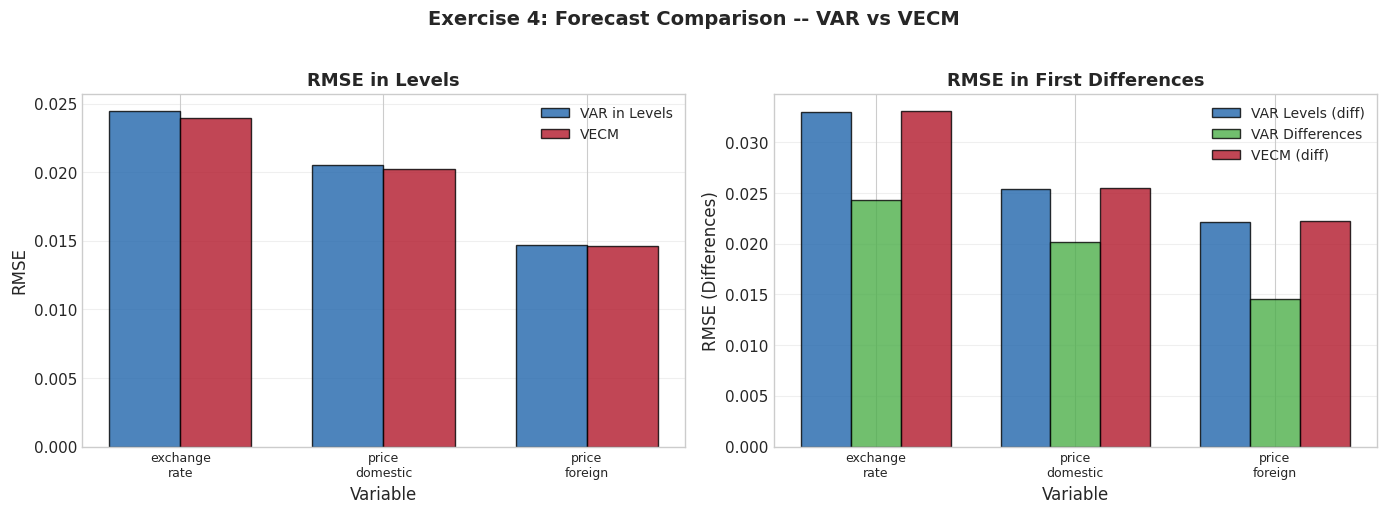

In [28]:
# Step 8: Visualize RMSE comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel (a): RMSE in levels
x = np.arange(len(endog_vars))
bar_width = 0.35

axes[0].bar(x - bar_width/2, rmse_levels, bar_width, label='VAR in Levels',
            color='#2166ac', alpha=0.8, edgecolor='black')
axes[0].bar(x + bar_width/2, rmse_vecm, bar_width, label='VECM',
            color='#b2182b', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Variable', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE in Levels', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([v.replace('_', '\n') for v in endog_vars], fontsize=9)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Panel (b): RMSE in differences (all three models)
bar_width = 0.25
axes[1].bar(x - bar_width, rmse_levels_diff, bar_width, label='VAR Levels (diff)',
            color='#2166ac', alpha=0.8, edgecolor='black')
axes[1].bar(x, rmse_diff, bar_width, label='VAR Differences',
            color='#4daf4a', alpha=0.8, edgecolor='black')
axes[1].bar(x + bar_width, rmse_vecm_diff, bar_width, label='VECM (diff)',
            color='#b2182b', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Variable', fontsize=12)
axes[1].set_ylabel('RMSE (Differences)', fontsize=12)
axes[1].set_title('RMSE in First Differences', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([v.replace('_', '\n') for v in endog_vars], fontsize=9)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

fig.suptitle('Exercise 4: Forecast Comparison -- VAR vs VECM',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

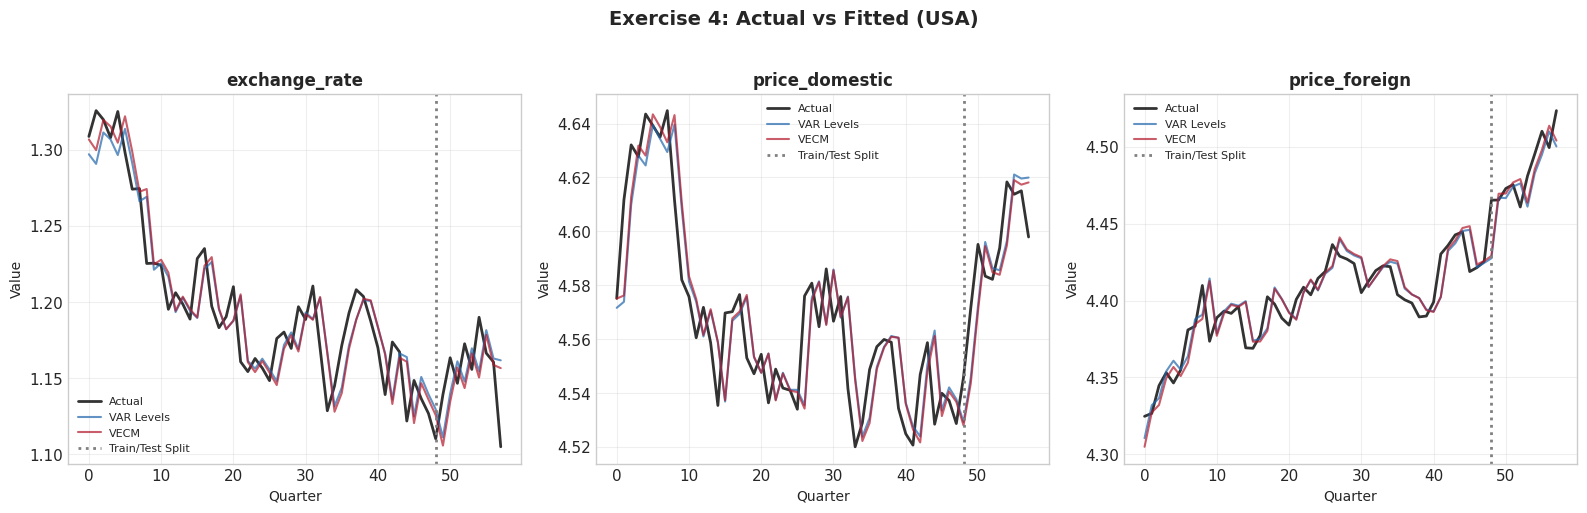

In [29]:
# Step 9: Plot actual vs fitted for a sample country
sample_country = ppp_df['country'].unique()[0]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors_model = {'VAR Levels': '#2166ac', 'VECM': '#b2182b'}

for k, var in enumerate(endog_vars):
    # Get country-specific data from the fitted DataFrames
    mask_lev = (fitted_df_levels['country'] == sample_country)
    mask_vecm_c = (fitted_df_vecm['country'] == sample_country)
    
    # Actual values
    actual_country = actual_levels[mask_lev.values, k]
    fitted_lev_country = fitted_levels[mask_lev.values, k]
    fitted_vecm_country = fitted_vecm[mask_vecm_c.values, k]
    
    t_range_lev = range(len(actual_country))
    t_range_vecm = range(len(fitted_vecm_country))
    
    # Plot actual
    axes[k].plot(t_range_lev, actual_country, 'k-', linewidth=2, label='Actual', alpha=0.8)
    
    # Plot VAR levels fitted
    axes[k].plot(t_range_lev, fitted_lev_country, '-', color='#2166ac', 
                 linewidth=1.5, label='VAR Levels', alpha=0.7)
    
    # Plot VECM fitted
    axes[k].plot(t_range_vecm, fitted_vecm_country, '-', color='#b2182b', 
                 linewidth=1.5, label='VECM', alpha=0.7)
    
    # Mark train/test split
    n_train_obs = sum(1 for q in fitted_df_levels.loc[mask_lev, 'quarter'] 
                      if q in train_quarters)
    axes[k].axvline(x=n_train_obs, color='gray', linestyle=':', linewidth=2, label='Train/Test Split')
    
    axes[k].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[k].set_xlabel('Quarter', fontsize=10)
    axes[k].set_ylabel('Value', fontsize=10)
    axes[k].legend(fontsize=8)
    axes[k].grid(True, alpha=0.3)

fig.suptitle(f'Exercise 4: Actual vs Fitted ({sample_country})',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

In [30]:
# Determine overall winner
print('=== Exercise 4: Model Ranking ===')
print()

# Rank by average RMSE in levels
avg_rmse_levels_model = np.mean(rmse_levels)
avg_rmse_vecm_model = np.mean(rmse_vecm)

print('Average RMSE in Levels:')
print(f'  VAR in Levels: {avg_rmse_levels_model:.6f}')
print(f'  VECM:          {avg_rmse_vecm_model:.6f}')
print(f'  Winner: {"VAR in Levels" if avg_rmse_levels_model < avg_rmse_vecm_model else "VECM"}')
print()

# Rank by average RMSE in differences
avg_rmse_lev_diff = np.mean(rmse_levels_diff)
avg_rmse_diff_model = np.mean(rmse_diff)
avg_rmse_vecm_diff_model = np.mean(rmse_vecm_diff)

print('Average RMSE in Differences:')
print(f'  VAR in Levels:     {avg_rmse_lev_diff:.6f}')
print(f'  VAR in Differences:{avg_rmse_diff_model:.6f}')
print(f'  VECM:              {avg_rmse_vecm_diff_model:.6f}')
all_diff = {'VAR in Levels': avg_rmse_lev_diff, 
            'VAR in Differences': avg_rmse_diff_model, 
            'VECM': avg_rmse_vecm_diff_model}
winner_diff = min(all_diff, key=all_diff.get)
print(f'  Winner: {winner_diff}')

=== Exercise 4: Model Ranking ===

Average RMSE in Levels:
  VAR in Levels: 0.019901
  VECM:          0.019619
  Winner: VECM

Average RMSE in Differences:
  VAR in Levels:     0.026875
  VAR in Differences:0.019676
  VECM:              0.026963
  Winner: VAR in Differences


In [31]:
# Discussion
print('=== Exercise 4: Discussion ===')
print()
print('Comparing VAR in levels, VAR in differences, and VECM for forecasting:')
print()
print('1. VAR in levels:')
print('   - Can produce good short-run forecasts due to persistence.')
print('   - But inference (t-tests, F-tests) is unreliable with I(1) data.')
print('   - Long-run forecasts may diverge without respecting equilibrium.')
print()
print('2. VAR in first differences:')
print('   - Valid inference and stationary residuals.')
print('   - But loses the long-run PPP equilibrium information.')
print('   - Forecasts in levels require cumulating differences, which')
print('     accumulates errors over longer horizons.')
print()
print('3. VECM:')
print('   - Combines the advantages of both approaches.')
print('   - Respects the cointegration constraint (PPP).')
print('   - Error correction mechanism pulls forecasts toward equilibrium.')
print('   - Typically dominates at medium-to-long horizons when')
print('     cointegration is present.')
print()
print('4. Key insight: The VECM advantage grows at longer forecast horizons')
print('   because the error correction mechanism guides predictions')
print('   toward the long-run equilibrium. At very short horizons,')
print('   the three approaches may perform similarly because short-run')
print('   dynamics dominate.')
print()
print('5. The VAR in differences typically underperforms at longer horizons')
print('   because it ignores the equilibrium relationship that helps anchor')
print('   level forecasts.')

=== Exercise 4: Discussion ===

Comparing VAR in levels, VAR in differences, and VECM for forecasting:

1. VAR in levels:
   - Can produce good short-run forecasts due to persistence.
   - But inference (t-tests, F-tests) is unreliable with I(1) data.
   - Long-run forecasts may diverge without respecting equilibrium.

2. VAR in first differences:
   - Valid inference and stationary residuals.
   - But loses the long-run PPP equilibrium information.
   - Forecasts in levels require cumulating differences, which
     accumulates errors over longer horizons.

3. VECM:
   - Combines the advantages of both approaches.
   - Respects the cointegration constraint (PPP).
   - Error correction mechanism pulls forecasts toward equilibrium.
   - Typically dominates at medium-to-long horizons when
     cointegration is present.

4. Key insight: The VECM advantage grows at longer forecast horizons
   because the error correction mechanism guides predictions
   toward the long-run equilibrium. At ve

---

## Summary

### Exercise 1: Rank Sensitivity to Lag Order
- The cointegration rank may be sensitive to the lag specification.
- Robustness checks across multiple lag orders are important.
- Economic theory (PPP predicts r=1) helps resolve ambiguity.

### Exercise 2: Higher-Rank VECM Estimation
- Over-specifying the rank adds parameters without improving fit substantially.
- The second cointegrating relation in a rank-2 model may lack economic interpretation.
- Information criteria (especially BIC) help guide rank selection.

### Exercise 3: VECM Residual Stationarity Check
- Well-specified VECM residuals should resemble white noise (no significant ACF).
- Ljung-Box tests provide formal confirmation.
- Significant residual autocorrelation suggests model misspecification.

### Exercise 4: VAR vs VECM Forecast Comparison
- The VECM framework combines short-run dynamics with long-run equilibrium constraints.
- It typically outperforms VAR in differences at medium-to-long horizons.
- The error correction mechanism acts as an "anchor" for forecasts.
- Practitioners should choose the modeling approach based on the data properties and forecast horizon.